## Analyze A/B Test Results

You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
# Importing necessary libraries and modules
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
# Setting a seed to assure the I get the same answers to the quizzes
random.seed(42)

In [2]:
# Disabling SettingWithCopyWarning
pd.set_option('mode.chained_assignment', None)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [3]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [4]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [5]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [6]:
df[df['converted'] == 1]['user_id'].nunique() / df['user_id'].nunique()

0.12104245244060237

e. The number of times the `new_page` and `treatment` don't match.

In [7]:
len(df.query('(group == "treatment" and not landing_page == "new_page") or'
             '(landing_page == "new_page" and not group == "treatment")'))

3893

f. Do any of the rows have missing values?

In [8]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [9]:
df2 = df[((df['group'] == 'treatment') == True) == ((df['landing_page'] == 'new_page') == True)]
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [11]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
df2[df2.user_id.duplicated() == True]['user_id']

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [13]:
df2[df2.user_id.duplicated() == True]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
df2.drop(2893, axis=0, inplace=True)

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
(df2.converted.value_counts() / len(df2))[1]

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
df2.groupby('group').converted.mean()['control']

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
df2.groupby('group').converted.mean()['treatment']

0.11880806551510564

d. What is the probability that an individual received the new page?

In [18]:
(df2.landing_page.value_counts() / len(df2))['new_page']

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**There is not enough evidence to make this conclusion, since the probability of receiving any of the pages is basically the same, as well as their conversion rate.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$H_0: p_{new} - P_{old} ≤ 0$$
$$H_1: p_{new} - p_{old} > 0$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [19]:
p_new = (df2.converted.value_counts() / len(df2))[1]
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [20]:
p_old = (df2.converted.value_counts() / len(df2))[1]
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [21]:
treatment_df = df2.query('group == "treatment"')
n_new = treatment_df.shape[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [22]:
control_df = df2.query('group == "control"')
n_old = control_df.shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
# Using np.random.choice to simulate the transactions
new_page_converted = np.random.choice(2, n_new, p=(1-p_new, p_new))
p_new_simul = new_page_converted.mean()
p_new_simul

0.12015690592526324

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
# Using np.random.choice to simulate the transactions
old_page_converted = np.random.choice(2, n_old, p=(1-p_old, p_old))
p_old_simul = old_page_converted.mean()
p_old_simul

0.11951209438715805

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [25]:
obs_diff = p_new_simul - p_old_simul
obs_diff

0.0006448115381051805

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [26]:
# Creating p_diffs
p_diffs = list()
# Setting sample size
samp_size = df.shape[0]
for i in range(10000):
    # Selecting a sample
    samp = df2.sample(samp_size, replace=True)
    # Simulating transactions
    p_new_simul = np.random.choice(2, n_new, p=(1-p_new, p_new)).mean()
    p_old_simul = np.random.choice(2, n_old, p=(1-p_old, p_old)).mean()
    # Appending simulated transactions on p_diffs
    p_diffs.append(p_new_simul - p_old_simul)

# Checking p_diffs
p_diffs[:10]

[0.00089252874456687,
 -0.0009725553106987861,
 0.001856250513038643,
 0.001938979240950281,
 0.0008720912834569855,
 8.051780798275232e-05,
 -0.0016609506595481743,
 0.002028267492399649,
 0.0002665303955772108,
 0.0002458558877728445]

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

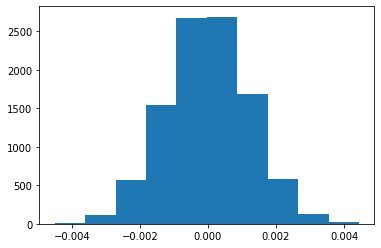

In [27]:
# Checking p_diffs distribution, it's expected to be a normal distribution
p_diffs = np.array(p_diffs)
plt.hist(p_diffs);

According to the [Central Limit Theorem](https://en.wikipedia.org/wiki/Central_limit_theorem), the distribution of the sample mean should be normal if the sample size is large enough, hence the result was as expected.

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [28]:
# Calculating the actual difference in ab_data
actual_diff = (df2.query('group == "treatment"')['converted'].mean() - 
               df2.query('group == "control"')['converted'].mean())
actual_diff

-0.0015782389853555567

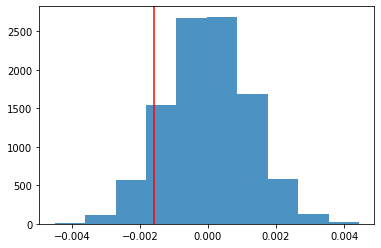

In [29]:
# Plotting distribution with a red line on the actual difference value
plt.hist(p_diffs, alpha=0.8);
plt.axvline(x=actual_diff, color='r');

In [30]:
# Computing the proportion of the p_diffs that are greater then the actual difference
(p_diffs > actual_diff).mean()

0.9015

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**I just computed the p-value, which is, by definition, the probability of obtaining the observed statistic or a more extreme value (a value that is more in favour of the alternate hypothesis mean) if the null hypothesis is true. 
In practical terms, as the p-value found is approximately 0.907, there is a 90.7% chance that the statistic I observed came from a population where the null hypothesis is true. Therefore, I fail to reject the null hypothesis, 
since there are no conclusive differences between the old and the new page.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [31]:
# Importing statsmodels API that will be used on the following cells
import statsmodels.api as sm

convert_old = df2.query('group == "control" and converted == 1').user_id.size
convert_new = df2.query('group == "treatment" and converted == 1').user_id.size
n_old = df2.query('group == "control"').user_id.size
n_new = df2.query('group == "treatment"').user_id.size
convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [32]:
z_score, p_value = sm.stats.proportions_ztest(count=[convert_new, convert_old], 
                                              nobs=[n_new, n_old], 
                                              alternative='larger')
z_score, p_value

(-1.3109241984234394, 0.9050583127590245)

In [33]:
# Finding critical value at 95% confidence
from scipy.stats import norm
norm.ppf(1-(0.05/2))

1.959963984540054

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**The z-score is another test of statistical significance that helps in deciding whether or not to reject the null,
basing on the number of standard deviations from the mean a data point is. When the z-score found is too large or too small and is associated with a very small p-value, it is unlikely that the observed pattern is a theoretically random pattern
represented by the null (strong evidence against the null).**  
**Since the obtained z-value of -1.31 does not exceed the critical value, which is between -1.96 and 1.96 at 95% confidence, and the p-value is large, I fail to reject the null hypothesis, according to the findings in parts j. and k.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic regression, since it will predict categorical data with one of two possible outcomes (whether a user will convert or not).**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [34]:
df2['intercept'] = 1
df2['ab_page'] = df2.group.map({'control': 0, 'treatment': 1})
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [35]:
logist_model = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = logist_model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [36]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 28 Apr 2020   Pseudo R-squ.:               8.077e-06
Time:                        14:47:25   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**The p-value associated with ab_page is 0.190.  
The reason it differs from the value found in Part II is because in the A/B test the alternative hypothesis is that the old page is better than, or equal to, the new (therefore, a one-tailed test). Regression, on other hand, is a two-tailed test, since the alternative hypothesis in Part III states that the the old page doesn't have the same effectiveness as the new page.  
Given that the p-value is greater than 0.05, I fail to reject the null hypothesis, indicating that the new page is not statistically significant in predicting whether a visitor will convert or not, when compared to the old page.**


f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Considering other factors may be relevant to the analysis once they may influence if a person converts or not. It is possible that the visitor's country, gender or age will interfere in his decision, for example.  
However, there are some disadvantages. For instance, although it is desired that the x-variables are related to the response, they should not be related to each other, since this results in multicollinearity, whose absence is one of the premises for the establishment of a correct regression model.  
Listed below are other [logistic regression assumptions](https://www.statisticssolutions.com/assumptions-of-logistic-regression/) to considerate when adding new variables to a regression:**

> <ul>
    <li>Binary logistic regression requires the dependent variable to be binary and ordinal logistic regression requires the dependent variable to be ordinal.</li>
    <li>Logistic regression requires the observations to be independent of each other.</li>
    <li>Logistic regression assumes linearity of independent variables and log odds.  although this analysis does not require the dependent and independent variables to be related linearly, it requires that the independent variables are linearly related to the log odds.</li>
    <li>Logistic regression typically requires a large sample size.  A general guideline is that you need at minimum of 10 cases with the least frequent outcome for each independent variable in your model.</li>
</ul>


g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [37]:
countries = pd.read_csv('countries.csv')
df_merged = countries.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_merged.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [38]:
df_merged[['CA', 'UK', 'US']] = pd.get_dummies(df_merged['country'])
df_merged.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [39]:
logist_model = sm.Logit(df_merged['converted'], df_merged[['intercept', 'CA', 'UK']])
results = logist_model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Tue, 28 Apr 2020   Pseudo R-squ.:               1.521e-05
Time:                        14:47:25   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
CA            -0.0408      0.027     -1.518      0.129      -0.093       0.012
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
==============================================================================
"""

In [40]:
# Checking how many times CA and UK are less and more likely to convert, respectively.
print('CA: ' + str(1/np.exp(-0.0408)))
print('UK: ' + str(np.exp(0.0099)))

CA: 1.0416437559600236
UK: 1.0099491671175422


**Compared to US overall conversions:**
><ul>
    <li>CA is 1.041 times less likely to convert.</li>
    <li>UK is 1.009 times more likely to convert.</li>
</ul>

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [41]:
# Creating new columns for the treatment group in each country
df_merged['UK_new_page'] = df_merged['UK'] * df_merged['ab_page']
df_merged['US_new_page'] = df_merged['US'] * df_merged['ab_page']
df_merged['CA_new_page'] = df_merged['CA'] * df_merged['ab_page']
df_merged.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US,UK_new_page,US_new_page,CA_new_page
user_id,,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,0,1,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,1,0,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,1,0,0


In [42]:
logist_model = sm.Logit(df_merged['converted'], df_merged[['intercept', 'CA_new_page', 'UK_new_page']])
results = logist_model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Tue, 28 Apr 2020   Pseudo R-squ.:               2.364e-05
Time:                        14:47:26   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                   0.08085
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept      -1.9963      0.006   -322.049      0.000      -2.008      -1.984
CA_new_page    -0.0752      0.038     -1.997      0.046      -0.149      -0.001
UK_new_page     0.0149      0.017      0.862      0.389      -0.019       0.049
===============================================================================
"""

In [43]:
# Checking how many times CA and UK treatment groups are less and more likely to convert, respectively.
print('CA - New Page: ' + str(1/np.exp(-0.0752)))
print('UK - New Page: ' + str(np.exp(0.0149)))

CA - New Page: 1.0780997492739288
UK - New Page: 1.0150115583846535


**Compared to US control group conversions:**
><ul>
    <li>CA treatment group is 1.078 times less likely to convert.</li>
    <li>UK treatment group is 1.015 times more likely to convert.</li>
</ul>

### Conclusions


When compared to the US control group, CA conversions are, on average, lower. Meanwhile, UK conversions are, on average, higher.  
Perhaps these differences may be the result of the aversion to change in Canada (in this case, the new page could be more accepted in the future), but even in the United Kingdom, as the positive difference is very small, I would not recommend moving to the new layout for practical reasons.

## References

<ul>
    <li><a>http://resources.esri.com/help/9.3/arcgisengine/java/gp_toolref/spatial_statistics_toolbox/what_is_a_z_score_what_is_a_p_value.htm</a></li>
    <li><a>https://www.statisticssolutions.com/assumptions-of-logistic-regression/</a></li>
    <li><a>https://en.wikipedia.org/wiki/Central_limit_theorem</a></li>
</ul>